<a href="https://colab.research.google.com/github/initialkermit/CS131_housing/blob/main/housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Remove rows with missing total_bedrooms
!awk -F, '{if($5 != "") print}' housing.csv > cleaned_housing.csv
# Filter outliers in median_house_value
!awk -F, 'NR==1 || ($9 <= 500000)' cleaned_housing.csv > no_outliers_housing.csv
# Filter extreme total_rooms
!awk -F, 'NR==1 || ($4 <= 10000)' no_outliers_housing.csv > final_housing.csv

In [10]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import time

First 5 rows of the preprocessed dataset:


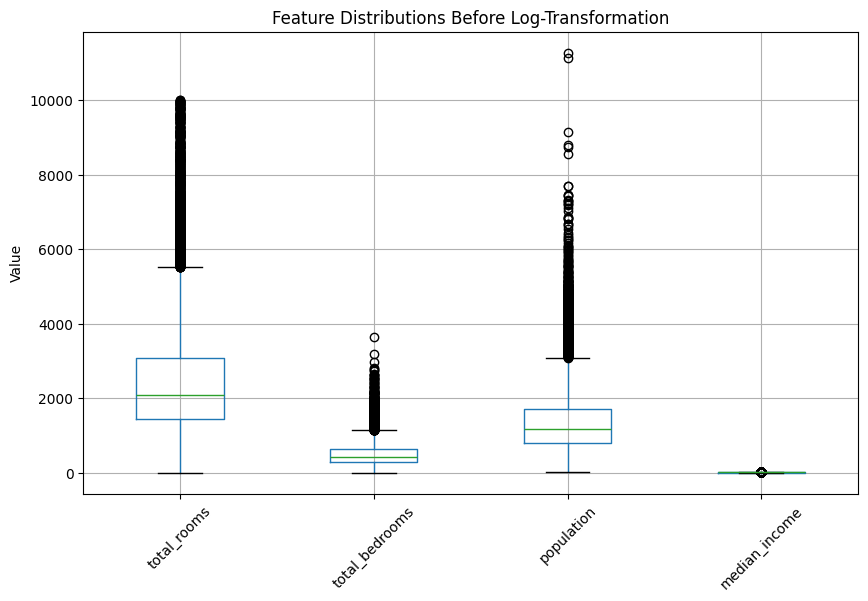

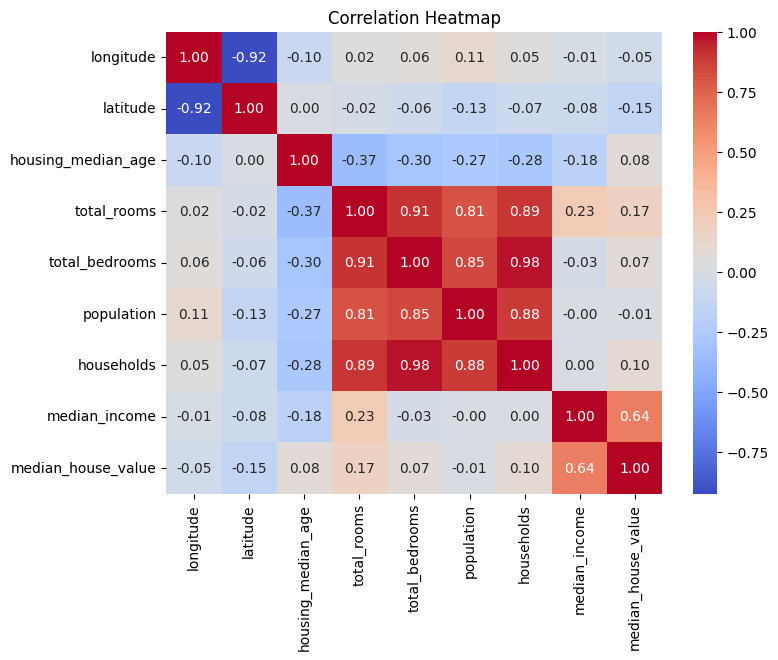

In [ ]:
# Load the preprocessed dataset
df = pd.read_csv('final_housing.csv')

# Display the first few rows
#df.head()

# Visualize feature distributions before transformation
plt.figure(figsize=(10, 6))
df[['total_rooms', 'total_bedrooms', 'population', 'median_income']].boxplot()
plt.title('Feature Distributions Before Log-Transformation')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Number of rows: 19211
Number of features after encoding: 13


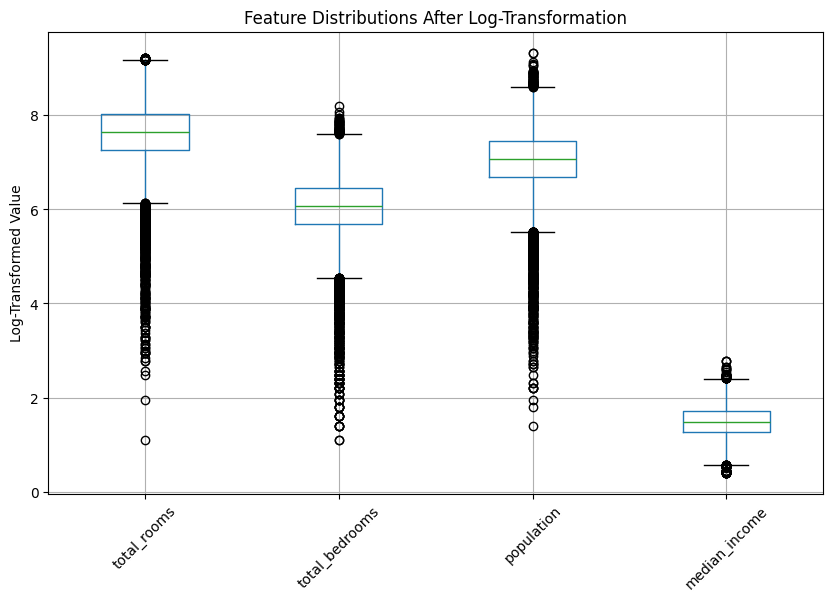

In [ ]:
# Log-transform skewed features
for col in ['total_rooms', 'total_bedrooms', 'population', 'median_income']:
    df[col] = np.log1p(df[col])  # log1p handles zero values

# One-hot encode ocean_proximity
df = pd.get_dummies(df, columns=['ocean_proximity'], prefix='ocean')

# Separate features and target
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# Scale the target
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Print dataset info
print(f"Number of rows: {len(df)}")
print(f"Number of features after encoding: {X.shape[1]}")

# Visualize feature distributions after transformation
plt.figure(figsize=(10, 6))
df[['total_rooms', 'total_bedrooms', 'population', 'median_income']].boxplot()
plt.title('Feature Distributions After Log-Transformation')
plt.ylabel('Log-Transformed Value')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Split data: 80% train+validation, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Define function to create neural network model
def create_model(layer_sizes, learning_rate):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train_val_scaled.shape[1],)))
    for size in layer_sizes:
        model.add(layers.Dense(size, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

# Define hyperparameter grid
layer_sizes_options = [(128, 64, 32), (256, 128, 64), (64, 32, 16)]
learning_rates = [0.001, 0.01]
hyperparam_combinations = list(product(layer_sizes_options, learning_rates))

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Store results
results = []

# Perform 5-fold cross-validation for each hyperparameter combination
for layer_sizes, lr in hyperparam_combinations:
    fold_rmse, fold_mae, fold_r2 = [], [], []

    for train_idx, val_idx in kfold.split(X_train_val_scaled):
        X_train_fold = X_train_val_scaled[train_idx]
        y_train_fold = y_train_val[train_idx]
        X_val_fold = X_train_val_scaled[val_idx]
        y_val_fold = y_train_val[val_idx]

        # Create and train model
        model = create_model(layer_sizes, lr)
        early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        model.fit(X_train_fold, y_train_fold, epochs=200, batch_size=32,
                  validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping], verbose=0)

        # Predict and evaluate
        y_pred = model.predict(X_val_fold, verbose=0)

        # Inverse transform for metrics in original scale
        y_pred_orig = target_scaler.inverse_transform(y_pred)
        y_val_orig = target_scaler.inverse_transform(y_val_fold.reshape(-1, 1)).flatten()

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val_orig, y_pred_orig))
        mae = mean_absolute_error(y_val_orig, y_pred_orig)
        r2 = r2_score(y_val_orig, y_pred_orig)

        fold_rmse.append(rmse)
        fold_mae.append(mae)
        fold_r2.append(r2)

    # Store average metrics
    results.append({
        'Layer Sizes': layer_sizes,
        'Learning Rate': lr,
        'Avg RMSE': np.mean(fold_rmse),
        'Std RMSE': np.std(fold_rmse),
        'Avg MAE': np.mean(fold_mae),
        'Avg R²': np.mean(fold_r2)
    })

In [ ]:
# Create DataFrame for results
results_df = pd.DataFrame(results)

# Display results
print("Cross-Validation Results:")
results_df

Cross-Validation Results:


,Layer Sizes,Learning Rate,Avg RMSE,Std RMSE,Avg MAE,Avg R²
0,"(128, 64, 32)",0.001,47150.572944,353.413406,32138.221059,0.766321
1,"(128, 64, 32)",0.010,47592.308187,762.790000,32601.115716,0.761766
2,"(256, 128, 64)",0.001,46683.969178,605.660297,31770.194019,0.770865
3,"(256, 128, 64)",0.010,48505.104051,1205.353489,33607.778495,0.752779
4,"(64, 32, 16)",0.001,47532.958517,410.002529,32639.590680,0.762523
5,"(64, 32, 16)",0.010,48291.160672,652.837947,33643.865476,0.754890


Best Hyperparameters: Layer Sizes=(256, 128, 64), Learning Rate=0.001
Epoch 1/200
421/421 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0337 - val_loss: 0.0265
Epoch 2/200
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0202 - val_loss: 0.0135
Epoch 3/200
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0124 - val_loss: 0.0120
Epoch 4/200
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0118 - val_loss: 0.0111
Epoch 5/200
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 6/200
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0106
Epoch 7/200
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105 - val_loss: 0.0111
Epoch 8/200
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - val_loss: 0.0101
Epoch 9/200
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0101 - val_loss: 0.0104
Epoch 10/200
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0103 - val_loss: 0.0097
Epoch 11/200
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - los

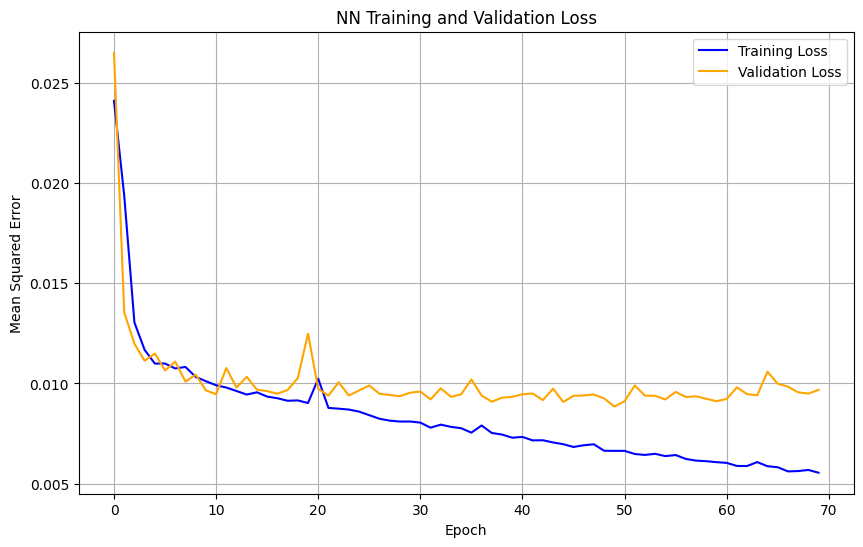

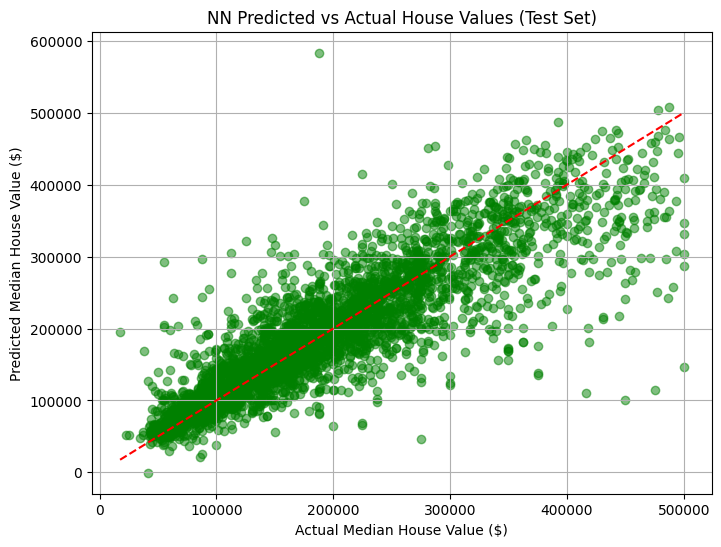

In [11]:
# Select best hyperparameters
best_params = results_df.loc[results_df['Avg RMSE'].idxmin()]
print(f"Best Hyperparameters: Layer Sizes={best_params['Layer Sizes']}, Learning Rate={best_params['Learning Rate']}")

# Split train_val into train and validation for final training
X_train, X_val, y_train, y_val = train_test_split(X_train_val_scaled, y_train_val, test_size=0.125, random_state=42)

# Train Neural Network
start_time = time.time()
nn_model = create_model(best_params['Layer Sizes'], best_params['Learning Rate'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = nn_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)
nn_train_time = time.time() - start_time

# Evaluate NN
y_train_pred_nn = nn_model.predict(X_train, verbose=0)
y_test_pred_nn = nn_model.predict(X_test_scaled, verbose=0)

# Inverse transform predictions
y_train_pred_nn = target_scaler.inverse_transform(y_train_pred_nn)
y_test_pred_nn = target_scaler.inverse_transform(y_test_pred_nn)
y_train_orig = target_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_orig = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate NN metrics
nn_train_rmse = np.sqrt(mean_squared_error(y_train_orig, y_train_pred_nn))
nn_train_mae = mean_absolute_error(y_train_orig, y_train_pred_nn)
nn_train_r2 = r2_score(y_train_orig, y_train_pred_nn)

nn_test_rmse = np.sqrt(mean_squared_error(y_test_orig, y_test_pred_nn))
nn_test_mae = mean_absolute_error(y_test_orig, y_test_pred_nn)
nn_test_r2 = r2_score(y_test_orig, y_test_pred_nn)

# Display NN results
print(f"NN Training Time: {nn_train_time:.2f} seconds")
print(f"NN Training RMSE: {nn_train_rmse:.2f}")
print(f"NN Training MAE: {nn_train_mae:.2f}")
print(f"NN Training R²: {nn_train_r2:.4f}")
print(f"NN Test RMSE: {nn_test_rmse:.2f}")
print(f"NN Test MAE: {nn_test_mae:.2f}")
print(f"NN Test R²: {nn_test_r2:.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('NN Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot of predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_orig, y_test_pred_nn, alpha=0.5, color='green')
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.title('NN Predicted vs Actual House Values (Test Set)')
plt.xlabel('Actual Median House Value ($)')
plt.ylabel('Predicted Median House Value ($)')
plt.grid(True)
plt.show()

DT Training Time: 0.17 seconds
DT Training RMSE: 43845.41
DT Training MAE: 30901.48
DT Training R²: 0.7985
DT Test RMSE: 57696.52
DT Test MAE: 39287.69
DT Test R²: 0.6566


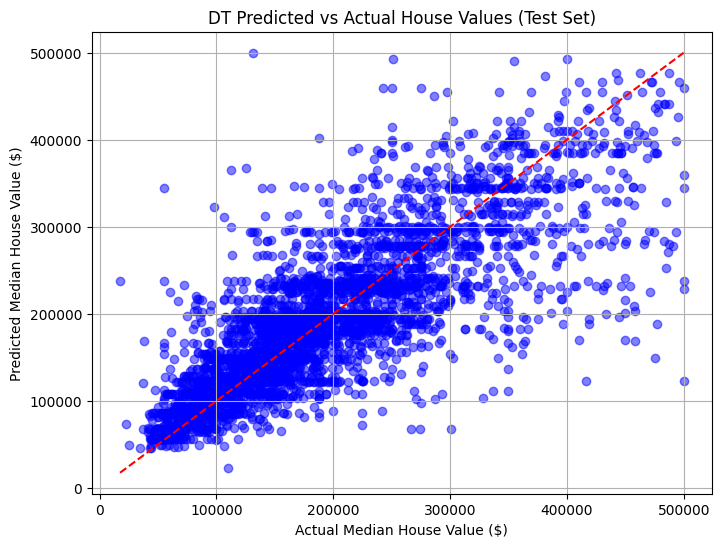

In [21]:
# Train Decision Tree with Tuning
start_time = time.time()
dt_model = DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_split=10)
dt_model.fit(X_train, y_train)
dt_train_time = time.time() - start_time

# Evaluate DT
y_train_pred_dt = dt_model.predict(X_train)
y_test_pred_dt = dt_model.predict(X_test_scaled)

# Inverse transform predictions
y_train_pred_dt = target_scaler.inverse_transform(y_train_pred_dt.reshape(-1, 1)).flatten()
y_test_pred_dt = target_scaler.inverse_transform(y_test_pred_dt.reshape(-1, 1)).flatten()

# Calculate DT metrics
dt_train_rmse = np.sqrt(mean_squared_error(y_train_orig, y_train_pred_dt))
dt_train_mae = mean_absolute_error(y_train_orig, y_train_pred_dt)
dt_train_r2 = r2_score(y_train_orig, y_train_pred_dt)

dt_test_rmse = np.sqrt(mean_squared_error(y_test_orig, y_test_pred_dt))
dt_test_mae = mean_absolute_error(y_test_orig, y_test_pred_dt)
dt_test_r2 = r2_score(y_test_orig, y_test_pred_dt)

# Display DT results
print(f"DT Training Time: {dt_train_time:.2f} seconds")
print(f"DT Training RMSE: {dt_train_rmse:.2f}")
print(f"DT Training MAE: {dt_train_mae:.2f}")
print(f"DT Training R²: {dt_train_r2:.4f}")
print(f"DT Test RMSE: {dt_test_rmse:.2f}")
print(f"DT Test MAE: {dt_test_mae:.2f}")
print(f"DT Test R²: {dt_test_r2:.4f}")

# Scatter plot for DT
plt.figure(figsize=(8, 6))
plt.scatter(y_test_orig, y_test_pred_dt, alpha=0.5, color='blue')
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.title('DT Predicted vs Actual House Values (Test Set)')
plt.xlabel('Actual Median House Value ($)')
plt.ylabel('Predicted Median House Value ($)')
plt.grid(True)
plt.show()

SVM Training Time: 32.98 seconds
SVM Training RMSE: 61576.87
SVM Training MAE: 45799.87
SVM Training R²: 0.6025
SVM Test RMSE: 61875.40
SVM Test MAE: 46034.76
SVM Test R²: 0.6050


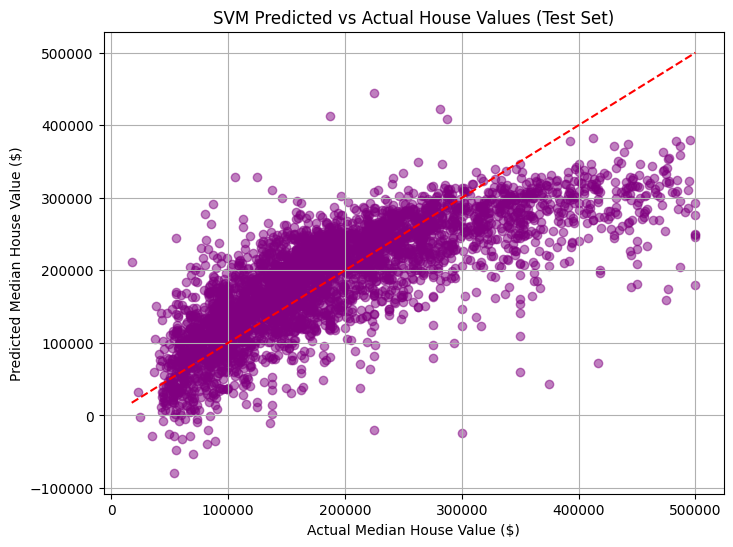

In [22]:
# Train Support Vector Machine (using linear kernel for speed)
start_time = time.time()
svm_model = SVR(kernel='linear')
svm_model.fit(X_train, y_train)
svm_train_time = time.time() - start_time

# Evaluate SVM
y_train_pred_svm = svm_model.predict(X_train)
y_test_pred_svm = svm_model.predict(X_test_scaled)

# Inverse transform predictions
y_train_pred_svm = target_scaler.inverse_transform(y_train_pred_svm.reshape(-1, 1)).flatten()
y_test_pred_svm = target_scaler.inverse_transform(y_test_pred_svm.reshape(-1, 1)).flatten()

# Calculate SVM metrics
svm_train_rmse = np.sqrt(mean_squared_error(y_train_orig, y_train_pred_svm))
svm_train_mae = mean_absolute_error(y_train_orig, y_train_pred_svm)
svm_train_r2 = r2_score(y_train_orig, y_train_pred_svm)

svm_test_rmse = np.sqrt(mean_squared_error(y_test_orig, y_test_pred_svm))
svm_test_mae = mean_absolute_error(y_test_orig, y_test_pred_svm)
svm_test_r2 = r2_score(y_test_orig, y_test_pred_svm)

# Display SVM results
print(f"SVM Training Time: {svm_train_time:.2f} seconds")
print(f"SVM Training RMSE: {svm_train_rmse:.2f}")
print(f"SVM Training MAE: {svm_train_mae:.2f}")
print(f"SVM Training R²: {svm_train_r2:.4f}")
print(f"SVM Test RMSE: {svm_test_rmse:.2f}")
print(f"SVM Test MAE: {svm_test_mae:.2f}")
print(f"SVM Test R²: {svm_test_r2:.4f}")

# Scatter plot for SVM
plt.figure(figsize=(8, 6))
plt.scatter(y_test_orig, y_test_pred_svm, alpha=0.5, color='purple')
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.title('SVM Predicted vs Actual House Values (Test Set)')
plt.xlabel('Actual Median House Value ($)')
plt.ylabel('Predicted Median House Value ($)')
plt.grid(True)
plt.show()

Model Comparison (Test Set):


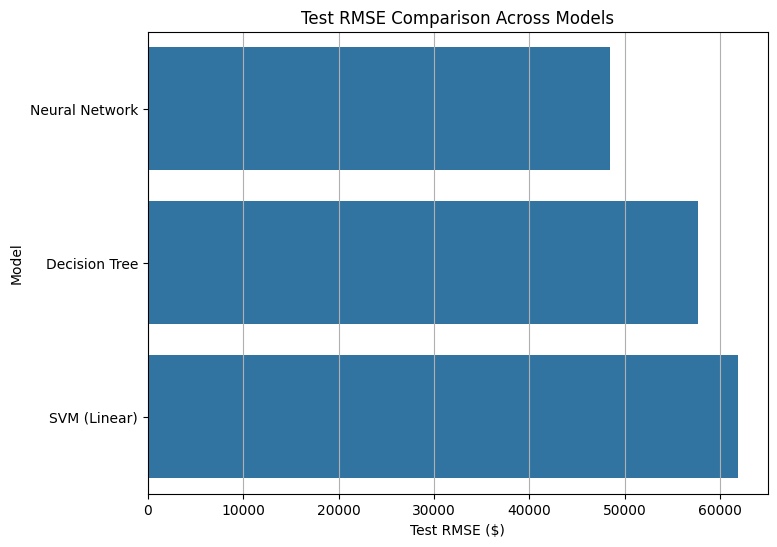

In [23]:
# Compare models
comparison_data = {
    'Model': ['Neural Network', 'Decision Tree', 'SVM (Linear)'],
    'Training Time (s)': [nn_train_time, dt_train_time, svm_train_time],
    'Test RMSE': [nn_test_rmse, dt_test_rmse, svm_test_rmse],
    'Test MAE': [nn_test_mae, dt_test_mae, svm_test_mae],
    'Test R²': [nn_test_r2, dt_test_r2, svm_test_r2]
}
comparison_df = pd.DataFrame(comparison_data)

# Display comparison
print("Model Comparison (Test Set):")
comparison_df

# Bar plot of Test RMSE
plt.figure(figsize=(8, 6))
sns.barplot(x='Test RMSE', y='Model', data=comparison_df)
plt.title('Test RMSE Comparison Across Models')
plt.xlabel('Test RMSE ($)')
plt.ylabel('Model')
plt.grid(True, axis='x')
plt.show()